In [2]:
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from enum import Enum
from torch.utils.data import Dataset, DataLoader
import os

Graph with 70 nodes and 69 edges


C:\Users\User\AppData\Local\Temp\ipykernel_13360\1746115857.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(grafo)


{0: array([  5.85259, -68.4049 ], dtype=float32), 1: array([  6.60079, -68.7979 ], dtype=float32), 2: array([  6.8792, -68.9031], dtype=float32), 3: array([  7.08318, -69.078  ], dtype=float32), 4: array([  7.20717, -69.0861 ], dtype=float32), 5: array([  7.25022, -68.9839 ], dtype=float32), 6: array([  7.1948, -68.786 ], dtype=float32), 7: array([  7.12814, -68.5396 ], dtype=float32), 8: array([  7.09018, -68.3013 ], dtype=float32), 9: array([  7.03289, -68.0989 ], dtype=float32), 11: array([  5.50827, -70.4017 ], dtype=float32), 12: array([  5.09623, -69.7345 ], dtype=float32), 13: array([  4.97022, -69.4718 ], dtype=float32), 14: array([  4.8496, -69.2118], dtype=float32), 15: array([  4.76064, -68.9074 ], dtype=float32), 16: array([  4.71717, -68.6916 ], dtype=float32), 17: array([  4.69216, -68.4663 ], dtype=float32), 18: array([  4.71861, -68.2185 ], dtype=float32), 19: array([  4.81505, -67.8899 ], dtype=float32), 20: array([  4.94356, -67.6142 ], dtype=float32), 21: array([  5.

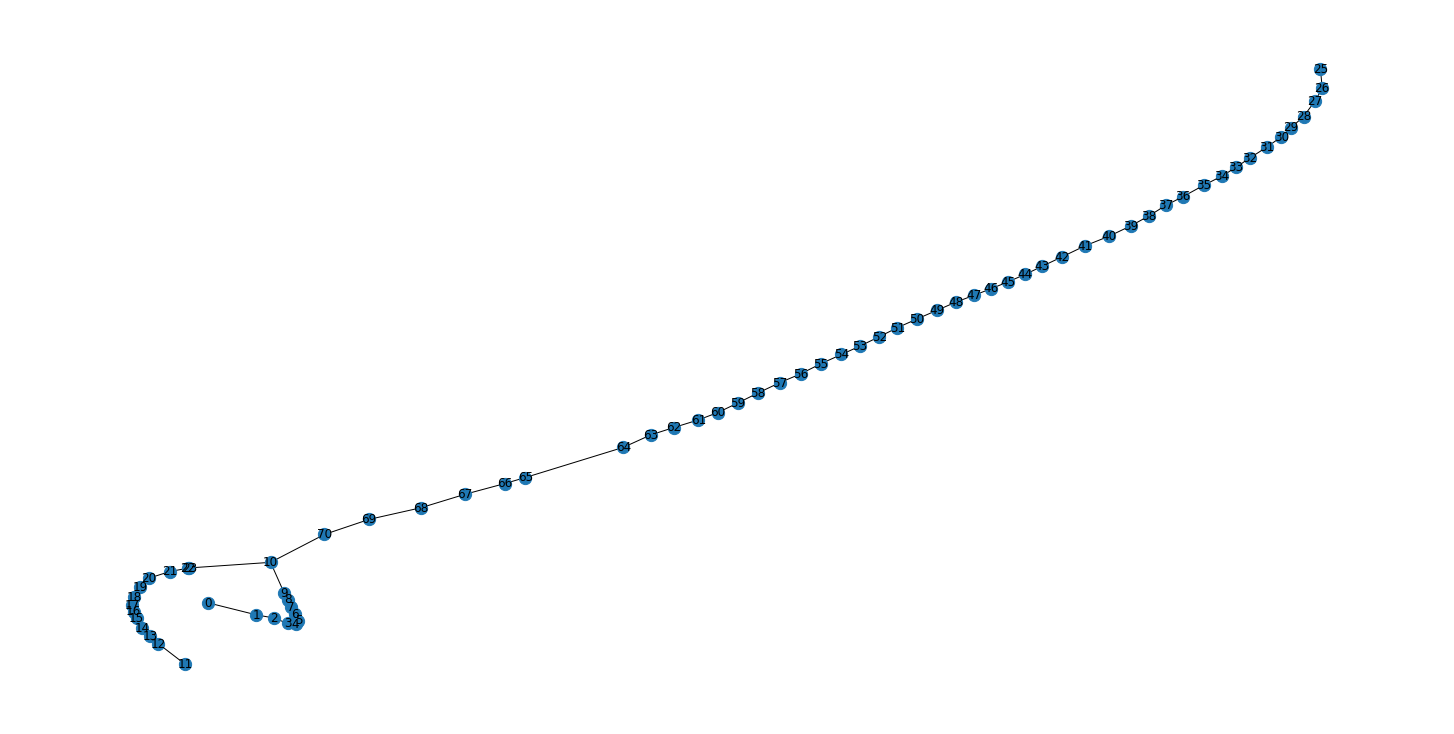

In [3]:
filename = "ArteryObjAN1-17"

grafo = pickle.load(open('grafos/' +filename + '-grafo.gpickle', 'rb'))
print(grafo)

a = nx.get_node_attributes(grafo, 'posicion')

for key in a.keys():
    a[key] = a[key].toNumpy()[0:2]

adjacency = nx.adjacency_matrix(grafo)
print(a)

plt.figure(figsize=(20,10))
nx.draw(grafo, pos = a, node_size = 150, with_labels = True)

Dataloader

In [5]:
g_list = os.listdir('./grafos')

In [38]:
for file in g_list:
    grafo = pickle.load(open('./grafos/' +file, 'rb'))
    adj = nx.to_numpy_array(grafo)
    np.save('./adj/' +file.split(".")[0], adj)

In [29]:
import numpy as np
from functools import partial

# save np.load
np_load_old = partial(np.load)

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)



In [30]:
class gDataset(Dataset):
    def __init__(self, transform=None):
        self.names = g_list
        self.transform = transform


    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        file = g_list[idx]
        #grafo = pickle.load(open('./adj/' +grafo, 'rb'))
        grafo = np.load('./adj/' +file.split(".")[0]+".npy")
        return grafo

dataset = gDataset()
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=True)

In [46]:
input_line = iter(data_loader).next()
print(input_line)
print(input_line.shape)

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 1., 0., 1.],
         [0., 0., 0.,  ..., 0., 1., 0.]]], dtype=torch.float64)
torch.Size([1, 38, 38])


In [15]:
np.load = np_load_old

Autoencoder

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, input_size, feature_size):
        super(Encoder, self).__init__()
        self.encoder = nn.Linear(input_size, feature_size)
        self.tanh = nn.Tanh()

    def forward(self, box_input):
        box_vector = self.encoder(box_input)
        box_vector = self.tanh(box_vector)
        return box_vector

In [ ]:
class GRASSEncoder(nn.Module):
    
    def __init__(self, config):
        super(GRASSEncoder, self).__init__()
        self.encoder = Encoder(input_size = config.box_code_size, feature_size = config.feature_size)
        
    def Encoder(self, box):
        return self.encoder(box)


def encode_structure_fold(fold, tree):#que es tree, que es node

    def encode_node(node):
        
        return fold.add('boxEncoder', node.box)
        

    encoding = encode_node(tree.root)
    return fold.add('sampleEncoder', encoding)

Loop de entrenamiento

In [ ]:
train_iter = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, collate_fn=my_collate)

In [ ]:
encoder = GRASSEncoder()
encoder_opt = torch.optim.Adam(encoder.parameters(), lr=1e-3)

In [ ]:
box_code_size = default=12
feature_size=80
hidden_size=200
symmetry_size=8
max_box_num=30
max_sym_num=10
epochs=300
batch_size=123
show_log_every=3
save_log=False
save_log_every=3
save_snapshot=False
save_snapshot_every=5
no_plot=False
lr=.001
lr_decay_by=1
lr_decay_every=1

no_cuda=False
gpu=0
data_path='data'
save_path='models'
resume_snapshot=''

In [ ]:

for epoch in range(epochs):
    
    for batch_idx, batch in enumerate(train_iter):
        # Initialize torchfold for *encoding*
        enc_fold = FoldExt(cuda=config.cuda) #foldext esta definido por ellos, todavia no entendi, creo que lo definen ellos pq trorch fold no soporta batch
        enc_fold_nodes = []     # list of fold nodes for encoding
        # Collect computation nodes recursively from encoding process
        for example in batch:
            enc_fold_nodes.append(encode_structure_fold(enc_fold, example))
        # Apply the computations on the encoder model
        enc_fold_nodes = enc_fold.apply(encoder, [enc_fold_nodes])
        # Split into a list of fold nodes per example
        enc_fold_nodes = torch.split(enc_fold_nodes[0], 1, 0)
        # Initialize torchfold for *decoding*
        dec_fold = FoldExt(cuda=config.cuda)
        # Collect computation nodes recursively from decoding process
        dec_fold_nodes = []
        kld_fold_nodes = []
        for example, fnode in zip(batch, enc_fold_nodes):
            root_code, kl_div = torch.chunk(fnode, 2, 1)
            dec_fold_nodes.append(grassmodel.decode_structure_fold(dec_fold, root_code, example))
            kld_fold_nodes.append(kl_div)
        # Apply the computations on the decoder model
        total_loss = dec_fold.apply(decoder, [dec_fold_nodes, kld_fold_nodes])
            # the first dim of total_loss is for reconstruction and the second for KL divergence
        recon_loss = total_loss[0].sum() / len(batch)               # avg. reconstruction loss per example
        kldiv_loss = total_loss[1].sum().mul(-0.05) / len(batch)    # avg. KL divergence loss per example
        total_loss = recon_loss + kldiv_loss
        # Do parameter optimization
        encoder_opt.zero_grad()
        decoder_opt.zero_grad()
        total_loss.backward()
        encoder_opt.step()
        decoder_opt.step()
        # Report statistics
        if batch_idx % config.show_log_every == 0:
            print(log_template.format(strftime("%H:%M:%S",time.gmtime(time.time()-start)),
                epoch, config.epochs, 1+batch_idx, len(train_iter),
                100. * (1+batch_idx+len(train_iter)*epoch) / (len(train_iter)*config.epochs),
                recon_loss.data[0], kldiv_loss.data[0], total_loss.data[0]))
       

    # Save training log
    if config.save_log and (epoch+1) % config.save_log_every == 0 :
        fd_log = open('training_log.log', mode='a')
        fd_log.write('\nepoch:{} recon_loss:{:.2f} kld_loss:{:.2f} total_loss:{:.2f}'.format(epoch+1, recon_loss.data[0], kldiv_loss.data[0], total_loss.data[0]))
        fd_log.close()

# Save the final models
print("Saving final models ...... ", end='', flush=True)
torch.save(encoder, config.save_path+'//vae_encoder_model.pkl')
torch.save(decoder, config.save_path+'//vae_decoder_model.pkl')
print("DONE")